In [1]:
import idaes.core.util.scaling as iscale
import numpy as np
import pyomo.environ as pyo
import pyomo.contrib.mpc as mpc
import pandas as pd

from idaes_examples.mod.power_gen.soc_nmpc.nmpc_tracking_LMP_settings import  (pred_horizon, 
                                        pred_step_num, 
                                        t_step,
                                        traj_time_set, 
                                        time_mark_list,
                                        sim_time_set,
                                        solver_v2,
                                        pass_all_vars_plant
                                        )
from idaes_examples.mod.power_gen.soc_nmpc.soec_attributes import SocAttr
import matplotlib.pyplot as plt
from idaes_examples.mod.power_gen.soc_nmpc.soec_model import get_MVs, get_dMVs, get_state_vars, create_model
from idaes_examples.mod.power_gen.soc_nmpc.soec_objectives import create_tracking_obj_expr, create_economic_obj_expr
from idaes_examples.mod.power_gen.soc_nmpc.soec_petsc_solver import petsc_initialize
from idaes_examples.mod.power_gen.soc_nmpc.soec_save_and_plot import Save, plot


# Reversible Solid Oxide Cell (rSOC) NMPC example
Authors: Sakshi Naik and Yufei Zhao

Maintainer: Douglas Allan

Updated:09-16-25

## 1. Introduction
This example is designed to demonstrate Nonlinear Model Predictive Control (NMPC) framework in a complex flowsheet to optimize rSOC operation. 


## 2. Model Description
The rSOC flowsheet is showing in the following figure, where the operation in fuel cell mode is shown in blue and in electrolysis mode is shown in red. The product streams from the rSOC, can be recycled back to the stack or can be vented out of the system. In the fuel cell mode, the flash unit is used to knock out water from the hydrogen-rich fuel gas from the cell stack to mix the hydrogen with the makeup stream. In the electrolysis mode, the hydrogen-rich gas after the flash is vented out of the system. In both modes, air is used in the sweep stream and is recycled using the sweep splitter or is vented out of the process.

The flowsheet also contains three heat exchangers for heat integration. The hot product streams from the rSOC stack are used to preheat the feed and sweep streams. Two trim heaters provide additional heat to the inlet streams of the stack. The net energy consumption of the flowsheet is the combined electricity consumed by the rSOC stack, the trim heaters, and the sweep blower. Heat exchangers and trim heaters use a 1D model, while the remaining supporting equipment units use the 0D models. 

![My Figure](figure.png)

Steady-state optimization was conducted to obtain setpoints of the manipulated variables and ramp linearly between different, predetermined setpoints. Ramping time is 10 mins, while settling time is 50 mins. For all simulations, the time discretization was set to be 75s, and the controller horizon was 375s i.e. 5 time steps into the future. The user can adjust the simulation time by setting sim_time_point (within range 361).

In [2]:
# Controller inputs
# Number of time points to simulate the plant
sim_time_point = 3

# Controller prediction Horizon
pred_step_num = 5
t_step = 75.0  # s
pred_horizon = pred_step_num * t_step

In [3]:
# Inputs to build the tracking trajectory
# Time when the first ramp starts 
# Here the first ramp starts at 1800 s (30 mins)
t_start = 30* 60 

# Ramp time - 600 s (10 mins)
t_ramp = 10 * 60

# Trajectory setting time 3000 s (50 mins)
t_settle = 50 * 60

In [4]:
# Build the setpoint trajectories
df_full = pd.read_csv("operations_new.csv", index_col=0)

df = df_full
df.reset_index(inplace=True)
df.loc[:, 'hour'] = df.index
df.set_index('hour', inplace=True)

n_hour_point, n_vars = df.shape

dt_set = [t_start]

scenario_names = ['t_start']
for k in range(n_hour_point - 1):
    dt_set.append(t_ramp)
    dt_set.append(t_settle)
    scenario_names.append('t_ramp')
    scenario_names.append('t_settle')

time_mark_list = [sum(dt_set[:j]) for j in range(len(dt_set) + 1)]
sim_horizon = time_mark_list[-1]

sim_nfe = int((sim_horizon) / t_step)
sim_time_set = np.linspace(0, sim_nfe*t_step, sim_nfe+1)
traj_time_set = np.linspace(0, sim_nfe*t_step+pred_horizon, sim_nfe+pred_step_num+1)

soc_attr = SocAttr()
var_targets = soc_attr.make_sp_trajs(traj_time_set)

## 4. Example plots of trajectories
The function plots the setpoint trajectories of H2 production, consumption and the power usage. The black dotted line indicates the simulation time of the system.

C:\Users\dallan\AppData\Local\Temp\ipykernel_43904\1936944946.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


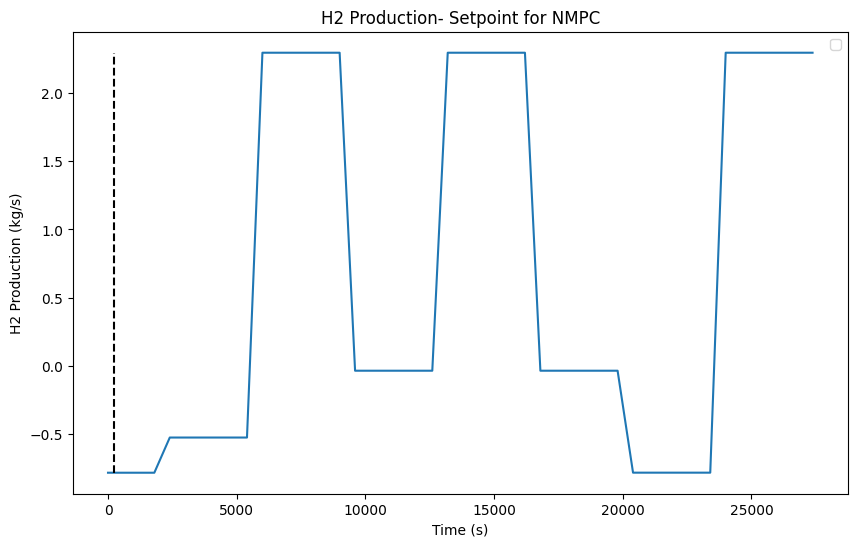

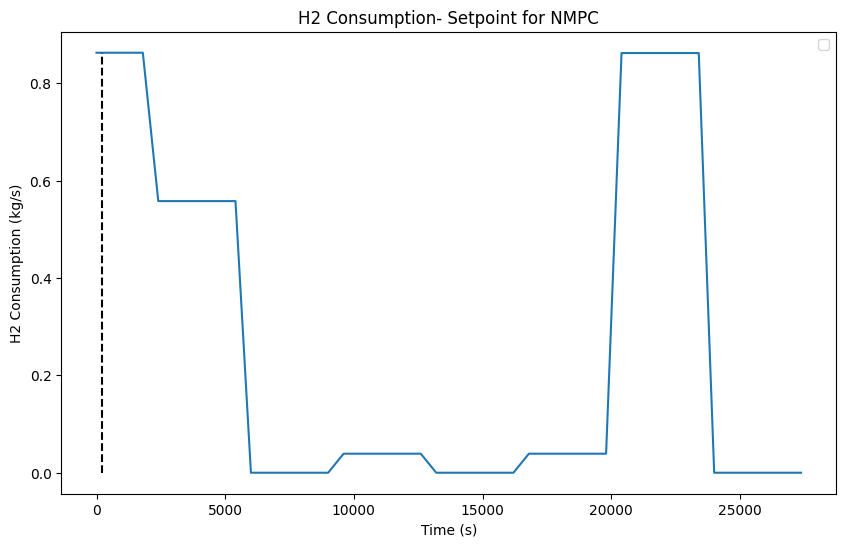

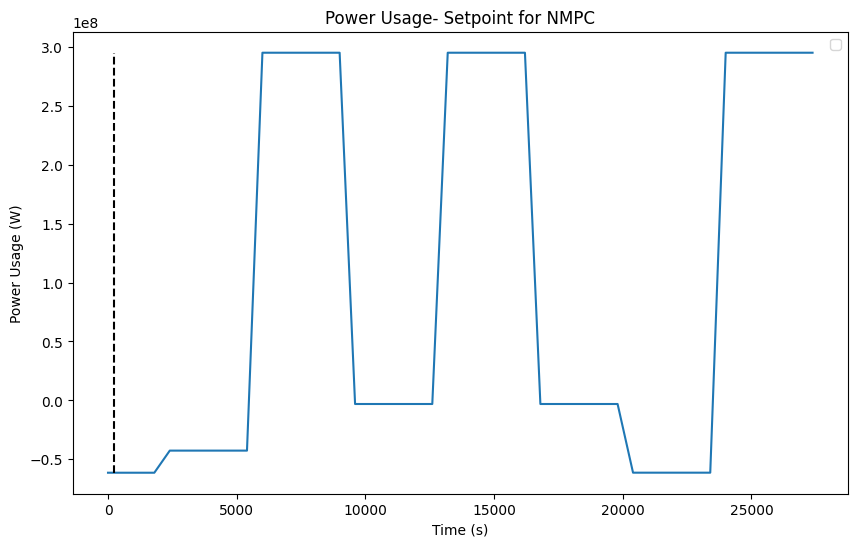

In [5]:
def plot_trajectories(vars_to_plot, traj_time_set, var_targets, sim_time_point):
    for var_name in vars_to_plot.keys():
        title = vars_to_plot[var_name]['title']
        unit = vars_to_plot[var_name]['unit']
        plt.figure(figsize=(10,6))

        sp_dict = var_targets[var_name] 
        sp = [sp_dict[t] for t in traj_time_set]
        plt.plot(traj_time_set, sp)
        
        _min_val = min(sp)
        _max_val = max(sp)
        plt.plot([sim_time_point*75,sim_time_point*75], [_min_val,_max_val], color='k', linestyle='--')
        plt.title(title + '- Setpoint for NMPC')
        plt.xlabel('Time (s)')
        plt.ylabel(title + ' (' + unit + ')')
        plt.legend()
        plt.show()

vars_to_plot = {'h2_production_rate': {'title': 'H2 Production', 'unit': 'kg/s'},
                'h2_consumption_rate': {'title': 'H2 Consumption', 'unit': 'kg/s'},
                'total_electric_power': {'title': 'Power Usage', 'unit': 'W'}}

plot_trajectories(vars_to_plot, traj_time_set, var_targets, sim_time_point)

## 5. NMPC model

In [6]:
def run_nmpc(economic= False, sim_time_point = None):
    
    if sim_time_point is None:
        raise ValueError("You must provide simultaion time")
    
    # Create controller model 
    controller_horizon = np.linspace(0, pred_horizon, pred_step_num + 1)
    controller_time_finite_elements = pred_step_num
    m_controller = create_model(controller_horizon, controller_time_finite_elements, plant = False, init_fname = "power_mode_nmpc.json.gz")
    m_controller.fs.p = pyo.Var(m_controller.fs.time, initialize = 0, domain = pyo.NonNegativeReals)
    m_controller.fs.n = pyo.Var(m_controller.fs.time, initialize = 0, domain = pyo.NonPositiveReals)

    @m_controller.fs.Constraint(m_controller.fs.time)
    def power_deviation(b, t):
        return b.total_electric_power[t] - b.total_electric_power_sp[t] == b.p[t] + b.n[t]
    
    if economic:
        obj_expr = create_economic_obj_expr
       
    else:
        obj_expr = create_tracking_obj_expr
        
    # Make controller objective before scaling
    m_controller.obj = pyo.Objective(rule=obj_expr, sense=pyo.minimize)

    iscale.scale_time_discretization_equations(m_controller, m_controller.fs.time, 1 / t_step)
    m_controller.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT_EXPORT)
    m_controller.ipopt_zL_out = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    m_controller.ipopt_zU_out = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    m_controller.ipopt_zL_in = pyo.Suffix(direction=pyo.Suffix.EXPORT)
    m_controller.ipopt_zU_in = pyo.Suffix(direction=pyo.Suffix.EXPORT)
    t0 = m_controller.fs.time.first()
        
    #Create controller interface
    controller_interface =  mpc.DynamicModelInterface(m_controller, m_controller.fs.time)

    #Create plant model
    plant_horizon = np.linspace(0, t_step, 2)
    plant_time_finite_elements = 1
    m_plant = create_model(plant_horizon, plant_time_finite_elements, plant=True, init_fname = "power_mode_nmpc.json.gz")

    #Scale the plant model
    iscale.scale_time_discretization_equations(m_plant, m_plant.fs.time, 1 / t_step)

    #Vars to fix in the plant
    control_vars = get_dMVs(m_controller)
    
    #Create plant interface
    plant_interface = mpc.DynamicModelInterface(m_plant, m_plant.fs.time)
    
    #Initialize the plant model using PETSC
    petsc_initialize(m_plant)
    non_initial_plant_time = list(m_plant.fs.time)[1:]
    
    #Fix initial MVs and DMVs in the controller
    #Note here the value the vars are fixed to doesn't matter because
    #the correct values to fix are loaded into the controller just after this
    for v in get_MVs(m_controller):
        v[t0].fix(0.0)
    for v in get_dMVs(m_controller):
        v[t0].fix(0.0)

    # Load the state of the plant at the last timepoint into the controller as
    # initial state
    ts_data = plant_interface.get_data_at_time(m_plant.fs.time.last())
    input_data_MV = ts_data.extract_variables(get_MVs(m_plant))
    input_data_dMV = ts_data.extract_variables(get_dMVs(m_plant))
    input_data_states = ts_data.extract_variables(get_state_vars(m_plant))

    controller_interface.load_data(input_data_MV, time_points=m_controller.fs.time.first())
    controller_interface.load_data(input_data_dMV, time_points=m_controller.fs.time.first())
    controller_interface.load_data(input_data_states, time_points=m_controller.fs.time.first())

    # Load the last state of the plant as the starting state of the plant
    plant_interface.load_data(input_data_MV, time_points=m_plant.fs.time.first())
    plant_interface.load_data(input_data_dMV, time_points=m_plant.fs.time.first())
    plant_interface.load_data(input_data_states, time_points=m_plant.fs.time.first())

    # Create soc attributes class instance
    soc_attr = SocAttr()
    var_targets = soc_attr.make_sp_trajs(traj_time_set)
    
    # Save initial plant data
    sim_data = plant_interface.get_data_at_time([0.0])
    
    # Initialize data dictionary
    data_dict = {}
    # Run the controller for the entire simulation time horizon
    for i in range(sim_time_point):
        t_base = sim_time_set[i]

        # Update setpoints
        soc_attr.update_sp(m_controller, t_base, var_targets)

        for t in m_controller.fs.time:
        # Update coefficients of the objective function based on setpoint
            if pyo.value(m_controller.fs.h2_target_sp[t]) >= 0:
                m_controller.h2_production_param[t] = 1
                m_controller.h2_consumption_param[t] = 0
            else:
                m_controller.h2_production_param[t] = 0
                m_controller.h2_consumption_param[t] = 1
               
        # Update coefficients
        soc_attr.update_coeff(m_controller)
        
        # Solve the scaled controller model
        try:
            print("Solving controller model at time = %f" %t_base)
            controller_results = solver_v2.solve(m_controller, tee= True)
            pyo.assert_optimal_termination(controller_results)
        except:
            print("Solving the controller failed")

        # Apply control actions to the plant model
        t1 = m_controller.fs.time.next(t0)
        controller_data = controller_interface.get_data_at_time(t1)
        vars_to_fix_in_plant = controller_data.extract_variables(control_vars)
        plant_interface.load_data(vars_to_fix_in_plant, time_points=non_initial_plant_time)


        # Save controller data
        controller_data_full = controller_interface.get_data_at_time(list(m_controller.fs.time))
        controller_data_full.shift_time_points(t_base - m_controller.fs.time.first())

        #Update plant variables 
        pass_all_vars_plant(target_model=m_plant, source_model=m_controller)

        # Solve plant model
        try:
            print("Solving plant model at time = %f" %t_base)
            plant_results = solver_v2.solve(m_plant, tee= True)
            pyo.assert_optimal_termination(plant_results)
        except:
            print("Solving the plant failed")
        
        # Shift time points in plant
        m_data = plant_interface.get_data_at_time(non_initial_plant_time)
        m_data.shift_time_points(t_base - m_plant.fs.time.first())
        sim_data.concatenate(m_data)
        
        # Save plant simulation results
        print("Saving plant simulation results")
        Save(m_plant, var_targets, data_dict, t_base)
        # Re-initialize plant model
        tf_data = plant_interface.get_data_at_time(m_plant.fs.time.last())
        plant_interface.load_data(tf_data)

        # Re-initialize controller model
        controller_interface.shift_values_by_time(t1)
        controller_interface.load_data(tf_data, time_points=t0)
        
        # Update controller duals
        m_controller.ipopt_zL_in.update(m_controller.ipopt_zL_out)
        m_controller.ipopt_zU_in.update(m_controller.ipopt_zU_out)
    return data_dict

## Run NMPC

In [7]:
economic = True
data_dict_updated = run_nmpc(economic= economic, sim_time_point = sim_time_point)

2025-10-20 15:29:19 [WARNING] idaes.models.properties.modular_properties.transport_properties.no_method: Skipping construction of thermal conductivity for phase Liq
2025-10-20 15:29:19 [WARNING] idaes.models.properties.modular_properties.transport_properties.no_method: Skipping construction of dynamic viscosity for phase Liq
2025-10-20 15:29:38 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.condenser_flash.control_volume.properties_in[0.0].mole_frac_comp
2025-10-20 15:29:38 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.condenser_flash.control_volume.properties_in[75.0].mole_frac_comp
2025-10-20 15:29:38 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.condenser_flash.control_volume.properties_in[150.0].mole_frac_comp
2025-10-20 15:29:38 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.condenser_flash.control_volume.properties_in[225.0].mole_frac_comp
2025-10-20 15:29:38 [WARNING] idaes.core.util.scaling: Missing scali

## Plot results

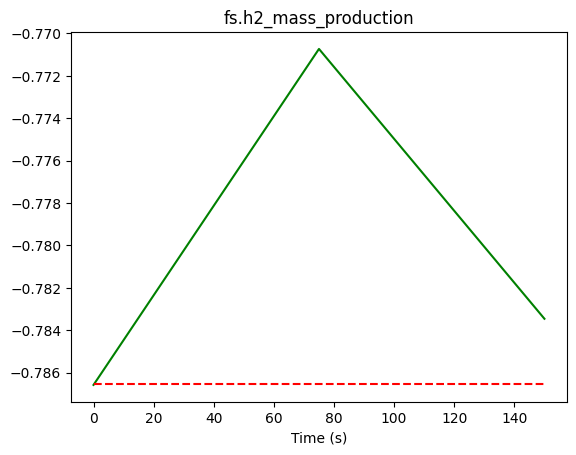

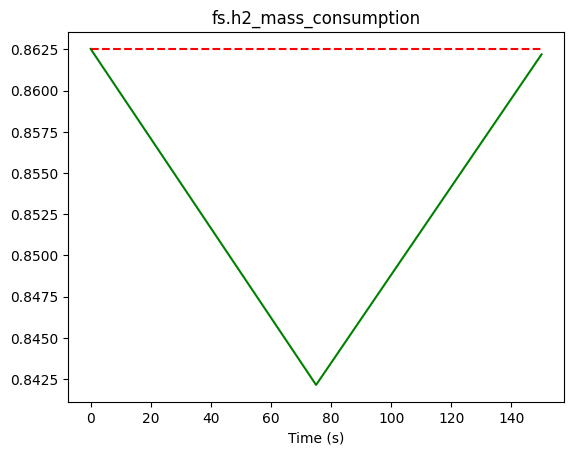

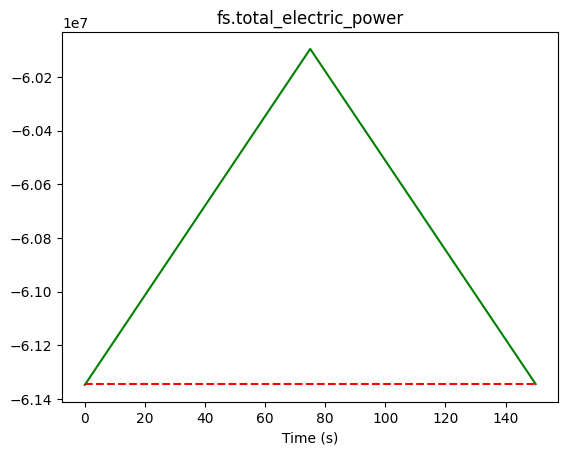

In [8]:
var_name = 'fs.h2_mass_production'
plot(var_name, data_dict_updated, scaling_factor=1)
var_name = 'fs.h2_mass_consumption'
plot(var_name, data_dict_updated, scaling_factor=1)
var_name = 'fs.total_electric_power'
plot(var_name, data_dict_updated, scaling_factor = 1)